text_encoder/model.safetensors not found
text_encoder/model.safetensors not found


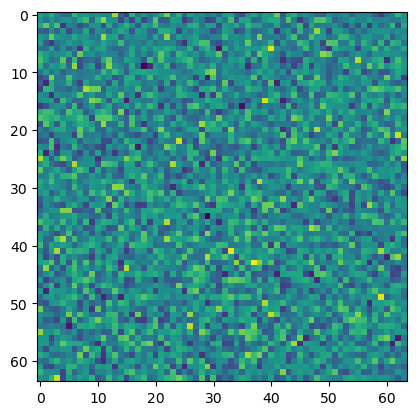

In [30]:
import argparse
import wandb
import copy
from tqdm import tqdm
from statistics import mean, stdev
import matplotlib.pyplot as plt

import torch

from inverse_stable_diffusion import InversableStableDiffusionPipeline
from diffusers import DPMSolverMultistepScheduler
import open_clip
from optim_utils import *
from io_utils import *

t = 0.1
def tol(x):
    if abs(x) < t:
        return x-t if x < 0 else x+t
    return x

class args():
    def __init__(self, channel, pattern, radius, mask_shape, id, seed=999999):
        self.w_channel = channel
        self.w_pattern = pattern
        self.w_radius = radius
        self.w_mask_shape = mask_shape
        self.w_seed = seed
        self.w_injection= "complex"
        self.model_id = id

if __name__ == '__main__':
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
  scheduler = DPMSolverMultistepScheduler.from_pretrained('stabilityai/stable-diffusion-2-1-base', subfolder='scheduler')
  pipe = InversableStableDiffusionPipeline.from_pretrained(
      'stabilityai/stable-diffusion-2-1-base',
      scheduler=scheduler,
      torch_dtype=torch.float32,
      revision='fp16',
      )
  pipe = pipe.to(device)

  init_latents_w = pipe.get_random_latents()
  
  #print(init_latents_w)
  
  
  flat_tensor = init_latents_w.view(-1)
  new_tensor = torch.tensor([tol(x.item()) for x in flat_tensor], dtype=init_latents_w.dtype)
  new_tensor = new_tensor.view(init_latents_w.shape)
  init_latents_w = new_tensor.to(device)

  args = args(3, "ring_tol", 10, "circle", 'stabilityai/stable-diffusion-2-1-base')
  
  watermarking_mask = get_watermarking_mask(init_latents_w, args, device)

  device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
  scheduler = DPMSolverMultistepScheduler.from_pretrained(args.model_id, subfolder='scheduler')
  pipe = InversableStableDiffusionPipeline.from_pretrained(
    args.model_id,
    scheduler=scheduler,
    torch_dtype=torch.float32,
    revision='fp16',
    )
  pipe = pipe.to(device)

# ground-truth patch
  gt_patch = get_watermarking_pattern(pipe, args, device)

  init_latents_w = inject_watermark(init_latents_w, watermarking_mask, gt_patch, args)
    
  t_to_img = np.squeeze(init_latents_w) # you can give axis attribute if you wanna squeeze in specific dimension 
  plt.imshow(t_to_img[1])
  torch.save(t_to_img, "input.pt")
  plt.show()


In [1]:
import argparse
import wandb
import copy
from tqdm import tqdm
from statistics import mean, stdev
import matplotlib.pyplot as plt

import torch

from inverse_stable_diffusion import InversableStableDiffusionPipeline
from diffusers import DPMSolverMultistepScheduler
import open_clip
from optim_utils import *
from io_utils import *

In [ ]:
t = 0.001
def tol(x):
    if abs(x) < t:
        return t+x if x < 0 else x-t
    return torch.randn(1)[0]

if __name__ == '__main__':
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
  scheduler = DPMSolverMultistepScheduler.from_pretrained('stabilityai/stable-diffusion-2-1-base', subfolder='scheduler')
  pipe = InversableStableDiffusionPipeline.from_pretrained(
      'stabilityai/stable-diffusion-2-1-base',
      scheduler=scheduler,
      torch_dtype=torch.float32,
      revision='fp16',
      )
  pipe = pipe.to(device)

  init_latents_w = pipe.get_random_latents()
  
  print(init_latents_w)
  
  
  flat_tensor = init_latents_w.view(-1)
  new_tensor = torch.tensor([tol(x) for x in flat_tensor], dtype=init_latents_w.dtype)
  new_tensor = new_tensor.view(init_latents_w.shape)
  init_latents_w = new_tensor.to(device)


  t = np.squeeze(init_latents_w) # you can give axis attribute if you wanna squeeze in specific dimension 
  val = copy.deepcopy(t) 

  
  val.apply_(lambda x:  1 if abs(x) < 0.001 else 0)
  print(f"{torch.sum(val)/(4096*val.shape[0])}")

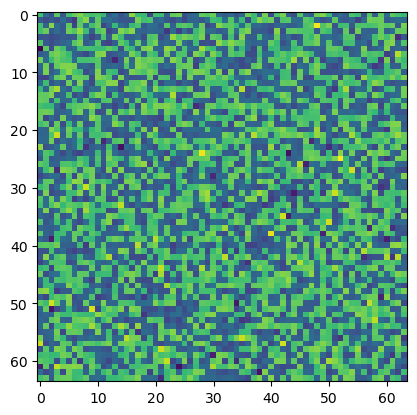

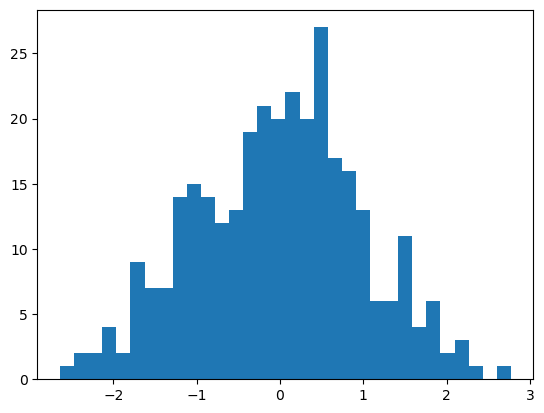

In [12]:
mark_i = torch.load('gt_init_tol')
mark_i = np.squeeze(mark_i) # you can give axis attribute if you wanna squeeze in specific dimension 
plt.imshow(mark_i[0])
plt.show()
mark_r = torch.load('target_ring_tol.pt')
plt.hist(mark_r, bins=32)
plt.show()

In [13]:
val_i = copy.deepcopy(mark_i) 
  
val_i.apply_(lambda x:  1 if abs(x) < 1 else 0)
print(f"{torch.sum(val_i)/(4096)}")

val_r = copy.deepcopy(mark_r) 
  
val_r.apply_(lambda x:  1 if abs(x) < 1 else 0)
print(f"{torch.sum(val_r)/(317)}")

0.0
0.6750788688659668


In [28]:
mark_r_blur = torch.load('target_ring_tol.pt')
val_r.apply_(lambda x:  1 if abs(x) < 1 else 0)
print(f"{torch.sum(val_r)/(4096)}")

0.48779296875


In [23]:
mark_i_base = torch.load('gt_init_ring')
val_i_base = copy.deepcopy(mark_i_base) 
  
val_i_base[0][0].apply_(lambda x:  1 if abs(x) < 1 else 0)
print(f"{torch.sum(val_i_base)/(4096)}")

mark_r_base = torch.load('target_ring.pt')
val_r_base = copy.deepcopy(mark_r_base[0]) 
  
val_r_base[0].apply_(lambda x:  1 if abs(x) < 1 else 0)
print(f"{torch.sum(val_r_base)/(4096)}")

0.6772336959838867
0.6233364343643188


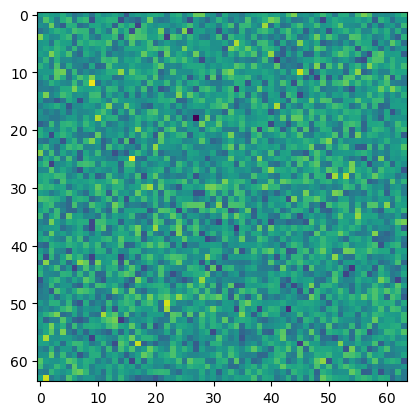

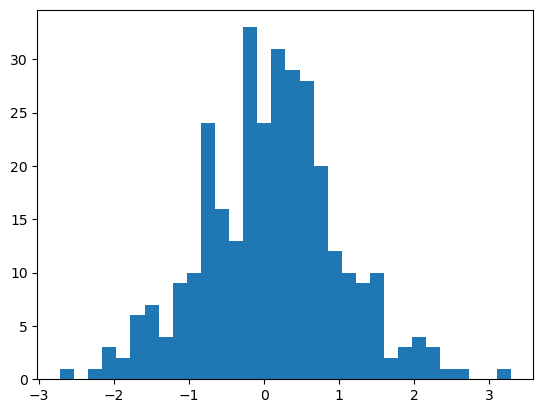

In [32]:
mark_i = torch.load('gt_init_prod')
mark_i = np.squeeze(mark_i) # you can give axis attribute if you wanna squeeze in specific dimension 
plt.imshow(mark_i[1])
plt.show()
mark_r = torch.load('target_ring_prop.pt')
plt.hist(mark_r, bins=32)
plt.show()

In [33]:
val_i = copy.deepcopy(mark_i[0]) 
  
val_i.apply_(lambda x:  1 if x > 0 else 0)
print(f"{torch.sum(val_i)/(4096)}")

val_r = copy.deepcopy(mark_r) 
  
val_r.apply_(lambda x:  1 if x > 0 else 0)
print(f"{torch.sum(val_r)/(317)}")

0.54345703125
0.5615141987800598


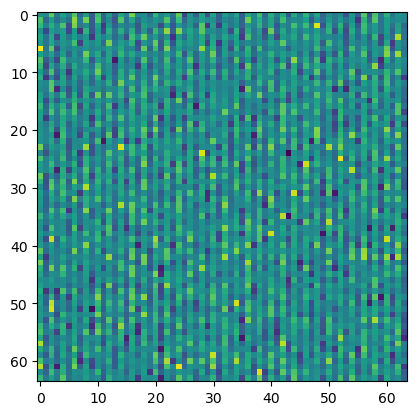

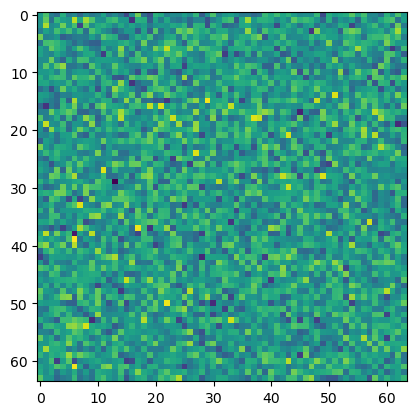

In [36]:
mark_i = torch.load('gt_patch_alt')
mark_i = np.squeeze(mark_i) # you can give axis attribute if you wanna squeeze in specific dimension 
plt.imshow(mark_i[0])
plt.show()
mark_r = torch.load('target_ring_alt.pt')
mark_r = np.squeeze(mark_r.real)
plt.imshow(mark_r[0])
plt.show()